In [42]:
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs
import matplotlib.pyplot as plt

from data_loading import *

pd.options.mode.copy_on_write = True

In [2]:
raw_df = load_price_data()
raw_df

/Users/stuartlu/Documents/雋寬資本/BettingAgainstBeta/data_loading.py:26: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  price = pd.read_csv(path, encoding='cp950')


Open      High       Low     Close  Volume  \
證券代碼     年月日                                                          
1101 台泥  2015-01-05   20.3688   20.3688   20.0872   20.1810    2842   
         2015-01-06   19.9464   19.9933   19.7586   19.8290    7654   
         2015-01-07   19.8290   19.9698   19.6413   19.7586    8719   
         2015-01-08   19.8290   20.0168   19.7586   19.8290    8697   
         2015-01-09   19.8525   19.9933   19.6178   19.6178   10494   
...                       ...       ...       ...       ...     ...   
9958 世紀鋼 2024-07-11  284.5000  287.5000  277.0000  278.0000    5667   
         2024-07-12  278.5000  285.0000  274.0000  274.5000    5254   
         2024-07-15  275.5000  276.0000  259.0000  265.0000   12310   
         2024-07-16  266.0000  266.5000  258.0000  263.5000    6468   
         2024-07-17  266.5000  269.5000  255.0000  255.5000    7778   

                     QuoteVolume  MarketCap  
證券代碼     年月日                                 
1101 台泥  2015-01-05       122244     158764  
         2015-01-06       324150     155994  
         2015-01-07       368171     155441  
         2015-01-08       369425     155994  
         2015-01-09       441333     154333  
...                          ...        ...  
9958 世紀鋼 2024-07-11      1590302      71417  
         2024-07-12      1462079      70518  
         2024-07-15      3257792      68078  
         2024-07-16      1690688      67692  
         2024-07-17      2023095      65637  

[2178483 rows x 7 columns]

In [27]:
df = raw_df[['Close']]
df = remove_special_stocks(df)
df.index.rename(['證券代碼', 'Date'], inplace=True)
df

Close
證券代碼     Date                
1101 台泥  2015-01-05   20.1810
         2015-01-06   19.8290
         2015-01-07   19.7586
         2015-01-08   19.8290
         2015-01-09   19.6178
...                       ...
9958 世紀鋼 2024-07-11  278.0000
         2024-07-12  274.5000
         2024-07-15  265.0000
         2024-07-16  263.5000
         2024-07-17  255.5000

[2145921 rows x 1 columns]

In [28]:
twii = yf.download('^TWII', start='2015-01-01', end='2024-07-18')
twii = twii[['Close']]
twii['證券代碼'] = 'TWII'
twii.set_index('證券代碼', append=True, inplace=True)
twii = twii.reorder_levels(['證券代碼', 'Date'])
twii.sort_index(
    level='證券代碼', inplace=True
)
twii

[*********************100%%**********************]  1 of 1 completed


Close
證券代碼 Date                    
TWII 2015-01-05   9274.110352
     2015-01-06   9048.339844
     2015-01-07   9080.089844
     2015-01-08   9238.030273
     2015-01-09   9215.580078
...                       ...
     2024-07-11  24390.029297
     2024-07-12  23916.929688
     2024-07-15  23879.359375
     2024-07-16  23997.250000
     2024-07-17  23769.820312

[2318 rows x 1 columns]

In [29]:
df = pd.concat([df, twii])
df

Close
證券代碼    Date                    
1101 台泥 2015-01-05     20.181000
        2015-01-06     19.829000
        2015-01-07     19.758600
        2015-01-08     19.829000
        2015-01-09     19.617800
...                          ...
TWII    2024-07-11  24390.029297
        2024-07-12  23916.929688
        2024-07-15  23879.359375
        2024-07-16  23997.250000
        2024-07-17  23769.820312

[2148239 rows x 1 columns]

In [30]:
# Apply the function to each group
df['YSTD Close'] = df.groupby('證券代碼')['Close'].shift(1)
df['logRet_1d'] = (df['Close'] / df['YSTD Close']).apply(np.log)
df['logRet_3d'] = df.groupby('證券代碼')['logRet_1d'].rolling(3).sum().reset_index(0,drop=True)
df['vol_120d'] = df.groupby('證券代碼')['logRet_1d'].rolling(120).std().reset_index(0,drop=True)

In [7]:
#df[df.index.get_level_values(level=0) == 'TWII'][df['logRet_3d'].isnull()]

In [31]:
# calculate 750-day rolling correlation

unstacked = df['logRet_3d'].unstack(0)
unstacked = unstacked[~unstacked['TWII'].isnull()]

corr = unstacked.rolling(750).corr(unstacked['TWII'])

df['corr_750d'] = corr.stack().reorder_levels([1, 0]).sort_index()

In [32]:
df[df['corr_750d'].isnull()]

Close    YSTD Close  logRet_1d  logRet_3d  \
證券代碼    Date                                                           
1101 台泥 2015-01-05     20.181000           NaN        NaN        NaN   
        2015-01-06     19.829000     20.181000  -0.017596        NaN   
        2015-01-07     19.758600     19.829000  -0.003557        NaN   
        2015-01-08     19.829000     19.758600   0.003557  -0.017596   
        2015-01-09     19.617800     19.829000  -0.010708  -0.010708   
...                          ...           ...        ...        ...   
TWII    2018-01-26  11147.099609  11165.950195  -0.001690  -0.009465   
        2018-01-29  11221.809570  11147.099609   0.006680   0.006226   
        2018-01-30  11076.780273  11221.809570  -0.013008  -0.008018   
        2018-01-31  11103.790039  11076.780273   0.002435  -0.003893   
        2018-02-01  11160.250000  11103.790039   0.005072  -0.005501   

                    vol_120d  corr_750d  
證券代碼    Date                             
1101 台泥 2015-01-05       NaN        NaN  
        2015-01-06       NaN        NaN  
        2015-01-07       NaN        NaN  
        2015-01-08       NaN        NaN  
        2015-01-09       NaN        NaN  
...                      ...        ...  
TWII    2018-01-26  0.005693        NaN  
        2018-01-29  0.005720        NaN  
        2018-01-30  0.005782        NaN  
        2018-01-31  0.005639        NaN  
        2018-02-01  0.005654        NaN  

[1054490 rows x 6 columns]

In [33]:
beta =  df[df.index.get_level_values('證券代碼') == '1101 台泥']['corr_750d']
beta.fillna(0)[beta.fillna(0) != 0]

證券代碼     Date      
1101 台泥  2019-08-06    0.437097
         2019-08-07    0.435326
         2019-08-08    0.432793
         2019-08-12    0.431716
         2019-08-13    0.432012
                         ...   
         2024-07-11    0.459674
         2024-07-12    0.459464
         2024-07-15    0.459138
         2024-07-16    0.458531
         2024-07-17    0.457461
Name: corr_750d, Length: 1203, dtype: float64

In [34]:
# calculate beta

vol_unstacked = df['vol_120d'].unstack('證券代碼')
beta = vol_unstacked.div(vol_unstacked['TWII'], axis=0) * corr
df['beta'] = beta.stack().reorder_levels([1, 0]).sort_index()
df['beta_lag1'] = df.groupby('證券代碼')['beta'].shift(1)
df['beta_lag2'] = df.groupby('證券代碼')['beta'].shift(2)

In [68]:
# function for sorting quantiles

def test_factor_performance(df, q = 10, factor = 'beta_last_month', returns = 'logRet_1d', reverse = False):

    df['Rank'] = df.groupby('Date')[factor].rank(ascending=reverse)
    df['Quantile'] = pd.qcut(df['Rank'], q=q, labels=[i for i in range(1, q+1)])

    # Calculate average return for each quantile on each date
    quantile_returns = df.groupby(['Date', 'Quantile'])[returns].mean().unstack()
    #quantile_returns['avg'] = df.groupby('Date')[returns].mean()
    #quantile_returns['long-short'] = quantile_returns[1] - quantile_returns[q]
    #plt.title('Daily Beta Performance')
    quantile_returns.cumsum().plot()
    
    qs.reports.metrics(quantile_returns)
    return quantile_returns

In [ ]:
# quantile with daily rebalance

stocks = df[df.index.get_level_values('證券代碼') != 'TWII'].dropna(how='any')
stocks

Close  YSTD Close  logRet_1d  logRet_3d  vol_120d  \
證券代碼     Date                                                               
1101 台泥  2019-08-08   27.1283     26.7884   0.012609   0.008005  0.009818   
         2019-08-12   27.1592     27.1283   0.001138   0.014901  0.009806   
         2019-08-13   26.6371     27.1592  -0.019411  -0.005664  0.009985   
         2019-08-14   27.3880     26.6371   0.027800   0.009527  0.010168   
         2019-08-15   27.1735     27.3880  -0.007863   0.000526  0.010097   
...                       ...         ...        ...        ...       ...   
9958 世紀鋼 2024-07-11  278.0000    281.5000  -0.012511   0.009033  0.037464   
         2024-07-12  274.5000    278.0000  -0.012670  -0.019838  0.037481   
         2024-07-15  265.0000    274.5000  -0.035221  -0.060403  0.037632   
         2024-07-16  263.5000    265.0000  -0.005676  -0.053568  0.037612   
         2024-07-17  255.5000    263.5000  -0.030831  -0.071729  0.037160   

                     corr_750d      beta  beta_lag1  beta_lag2  
證券代碼     Date                                                   
1101 台泥  2019-08-08   0.432793  0.633267   0.639596   0.637353  
         2019-08-12   0.431716  0.630586   0.633267   0.639596  
         2019-08-13   0.432012  0.636030   0.630586   0.633267  
         2019-08-14   0.431384  0.648143   0.636030   0.630586  
         2019-08-15   0.430749  0.637011   0.648143   0.636030  
...                        ...       ...        ...        ...  
9958 世紀鋼 2024-07-11   0.215397  0.799377   0.808801   0.816439  
         2024-07-12   0.214905  0.783459   0.799377   0.808801  
         2024-07-15   0.214734  0.785566   0.783459   0.799377  
         2024-07-16   0.216022  0.790303   0.785566   0.783459  
         2024-07-17   0.216719  0.778812   0.790303   0.785566  

[1086779 rows x 9 columns]

/var/folders/q_/2nhldr_d2x723c91y7qt5g2r0000gn/T/ipykernel_58156/3830066440.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_returns = df.groupby(['Date', 'Quantile'])[returns].mean().unstack()
/Users/stuartlu/anaconda3/envs/ml-taiwan-stockpicks/lib/python3.12/site-packages/quantstats/stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    1           2           3           4           5           6           7           8           9           10
------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start Period        2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08
End Period          2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17
Risk-Free Rate      0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%
Time in Market      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%

Cumulative Return   76.12%      91.27%      102.7%      77.88%      101.64%     82.81%      103.85%     80.66%      78.33%      139.64%
CAGR﹪              8.22%       9.48%       10.3

/Users/stuartlu/anaconda3/envs/ml-taiwan-stockpicks/lib/python3.12/site-packages/quantstats/stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    1           2           3           4           5           6           7           8           9           10
------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start Period        2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08  2019-08-08
End Period          2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17
Risk-Free Rate      0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%
Time in Market      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%

Cumulative Return   76.12%      91.27%      102.7%      77.88%      101.64%     82.81%      103.85%     80.66%      78.33%      139.64%
CAGR﹪              8.22%       9.48%       10.3

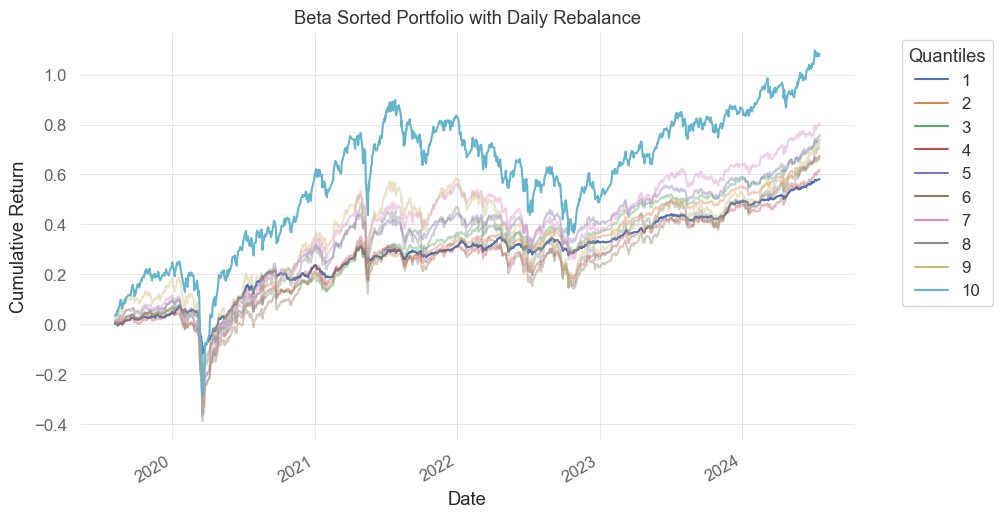

In [ ]:
returns_daily_rebalanced = test_factor_performance(stocks, factor = 'beta_lag1', returns = 'logRet_1d', reverse = True)


#returns_daily_rebalanced.cumsum().plot(figsize=(12, 6))
plt.title('Beta Sorted Portfolio with Daily Rebalance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(title='Quantiles', bbox_to_anchor=(1.05, 1), loc='upper left')

# Make other quantiles transparent and highlight 1st and 10th quantiles
for i in range(1, 9):
    plt.gca().get_lines()[i].set_alpha(0.4)

/var/folders/q_/2nhldr_d2x723c91y7qt5g2r0000gn/T/ipykernel_58156/3830066440.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quantile_returns = df.groupby(['Date', 'Quantile'])[returns].mean().unstack()
/Users/stuartlu/anaconda3/envs/ml-taiwan-stockpicks/lib/python3.12/site-packages/quantstats/stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    1           2           3           4           5           6           7           8           9           10
------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start Period        2019-09-02  2019-09-02  2019-09-02  2019-09-02  2019-09-02  2019-09-02  2019-09-02  2019-09-02  2019-09-02  2019-09-02
End Period          2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17  2024-07-17
Risk-Free Rate      0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%        0.0%
Time in Market      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%      100.0%

Cumulative Return   82.98%      92.67%      115.14%     70.4%       103.28%     66.23%      113.48%     79.38%      51.95%      106.99%
CAGR﹪              8.93%       9.73%       11.4

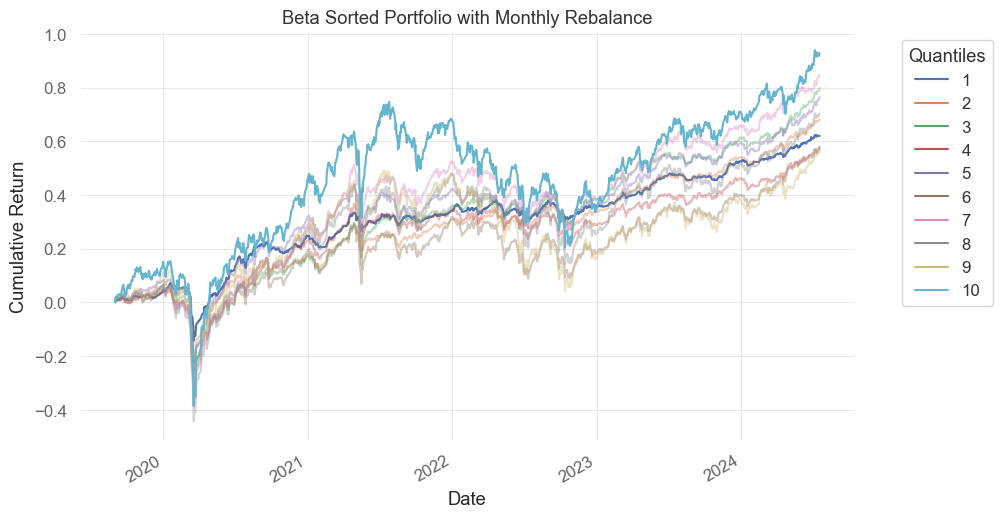

In [76]:
# test monthly quantile returns

stocks = df[df.index.get_level_values('證券代碼') != 'TWII'].dropna(how='any')

stocks['Month'] = stocks.index.get_level_values('Date').to_period('M')
stocks_monthly = stocks.groupby(['證券代碼', 'Month']).last()
stocks_monthly['beta_last_month'] = stocks_monthly.groupby('證券代碼')['beta'].shift(1)
stocks = stocks.merge(stocks_monthly[['beta_last_month']], left_on=['證券代碼', 'Month'], right_index=True)

test_factor_performance(stocks, factor = 'beta_last_month', returns = 'logRet_1d', reverse = True)

#returns_daily_rebalanced.cumsum().plot(figsize=(12, 6))
plt.title('Beta Sorted Portfolio with Monthly Rebalance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(title='Quantiles', bbox_to_anchor=(1.05, 1), loc='upper left')

# Make other quantiles transparent and highlight 1st and 10th quantiles
for i in range(1, 9):
    plt.gca().get_lines()[i].set_alpha(0.4)

/Users/stuartlu/anaconda3/envs/ml-taiwan-stockpicks/lib/python3.12/site-packages/quantstats/stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    high        low         bab
------------------  ----------  ----------  ----------
Start Period        2019-08-08  2019-08-08  2019-08-08
End Period          2024-07-17  2024-07-17  2024-07-17
Risk-Free Rate      0.0%        0.0%        0.0%
Time in Market      100.0%      100.0%      100.0%

Cumulative Return   141.6%      783.65%     312.29%
CAGR﹪              13.11%      35.55%      21.87%

Sharpe              0.75        1.28        1.42
Prob. Sharpe Ratio  94.45%      99.31%      99.56%
Sortino             0.98        1.6         1.84
Sortino/√2          0.69        1.13        1.3
Omega               1.15        1.15        1.15

Max Drawdown        -54.18%     -79.87%     -52.14%
Longest DD Days     870         392         441

Gain/Pain Ratio     0.15        0.3         0.33
Gain/Pain (1M)      0.69        1.17        1.18

Payoff Ratio        0.58        0.64        0.75
Profit Factor       1.15        1.3         1.33
Common Sense Ratio  0.94        1.19  

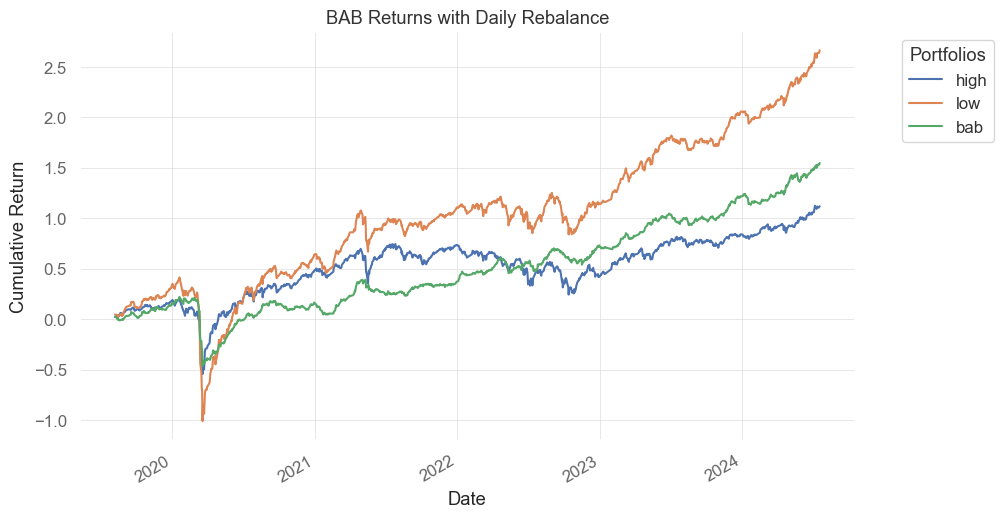

In [98]:
# now we calculate the BAB factor

stocks = df[df.index.get_level_values('證券代碼') != 'TWII'].dropna(how='any')
stocks['Month'] = stocks.index.get_level_values('Date').to_period('M')

stocks['beta_shrinked'] = stocks['beta'] * 0.6
stocks['beta_rank'] = stocks.groupby('Date')['beta_shrinked'].rank(ascending=True)

# assign high/low beta groups
stocks['beta_rank_avg'] = stocks.groupby('Date')['beta_rank'].transform('mean')

stocks['beta_rank_dev'] = stocks['beta_rank'] - stocks['beta_rank_avg']
stocks['beta_rank_abs_dev'] = stocks['beta_rank_dev'].abs()
stocks['k'] = 2 / stocks.groupby('Date')['beta_rank_abs_dev'].transform('sum')
stocks['w_h'] = np.maximum(stocks['beta_rank_dev'], 0) * stocks['k']
stocks['w_l'] = -np.minimum(stocks['beta_rank_dev'], 0) * stocks['k']
stocks['ret_h'] = stocks['w_h'].shift(1) * stocks['logRet_1d']
stocks['ret_l'] = stocks['w_l'].shift(1) * stocks['logRet_1d']
stocks['beta_h'] = stocks['w_h'].shift(1) * stocks['beta_shrinked'].shift(1)
stocks['beta_l'] = stocks['w_l'].shift(1) * stocks['beta_shrinked'].shift(1)

bab_return = pd.DataFrame()
bab_return['high'] = stocks.groupby('Date')['ret_h'].sum() / stocks.groupby('Date')['beta_h'].sum()
bab_return['low'] = stocks.groupby('Date')['ret_l'].sum() / stocks.groupby('Date')['beta_l'].sum()
bab_return['bab'] = bab_return['low'] - bab_return['high']

bab_return
bab_return.cumsum().plot()

qs.reports.metrics(bab_return)

plt.title('BAB Returns with Daily Rebalance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(title='Portfolios', bbox_to_anchor=(1.05, 1), loc='upper left')

In [99]:
# rebalance monthly

stocks_monthly = stocks.groupby(['證券代碼', 'Month']).last()
stocks_monthly['w_h_m'] = stocks_monthly['w_h'].shift(1)
stocks_monthly['w_l_m'] = stocks_monthly['w_l'].shift(1)
stocks_monthly['beta_h_m'] = stocks_monthly['w_h_m'] * stocks_monthly['beta_shrinked'].shift(1)
stocks_monthly['beta_l_m'] = stocks_monthly['w_l_m'] * stocks_monthly['beta_shrinked'].shift(1)

stocks = stocks.merge(stocks_monthly[['w_h_m', 'w_l_m', 'beta_h_m', 'beta_l_m']], left_on=['證券代碼', 'Month'], right_index=True)

stocks['ret_h_m'] = stocks['w_h_m'] * stocks['logRet_1d']
stocks['ret_l_m'] = stocks['w_l_m'] * stocks['logRet_1d']

/Users/stuartlu/anaconda3/envs/ml-taiwan-stockpicks/lib/python3.12/site-packages/quantstats/stats.py:510: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = _utils._prepare_returns(returns, rf).resample(resolution).sum()


                    high        low         bab
------------------  ----------  ----------  ----------
Start Period        2019-08-08  2019-08-08  2019-08-08
End Period          2024-07-17  2024-07-17  2024-07-17
Risk-Free Rate      0.0%        0.0%        0.0%
Time in Market      100.0%      100.0%      100.0%

Cumulative Return   127.59%     716.82%     337.64%
CAGR﹪              12.17%      34.07%      22.89%

Sharpe              0.72        1.17        1.25
Prob. Sharpe Ratio  93.6%       98.69%      98.64%
Sortino             0.93        1.46        1.58
Sortino/√2          0.66        1.03        1.12
Omega               1.14        1.14        1.14

Max Drawdown        -53.13%     -85.88%     -65.63%
Longest DD Days     934         422         443

Gain/Pain Ratio     0.14        0.29        0.33
Gain/Pain (1M)      0.65        1.21        1.33

Payoff Ratio        0.61        0.65        0.73
Profit Factor       1.14        1.29        1.33
Common Sense Ratio  0.92        1.15 

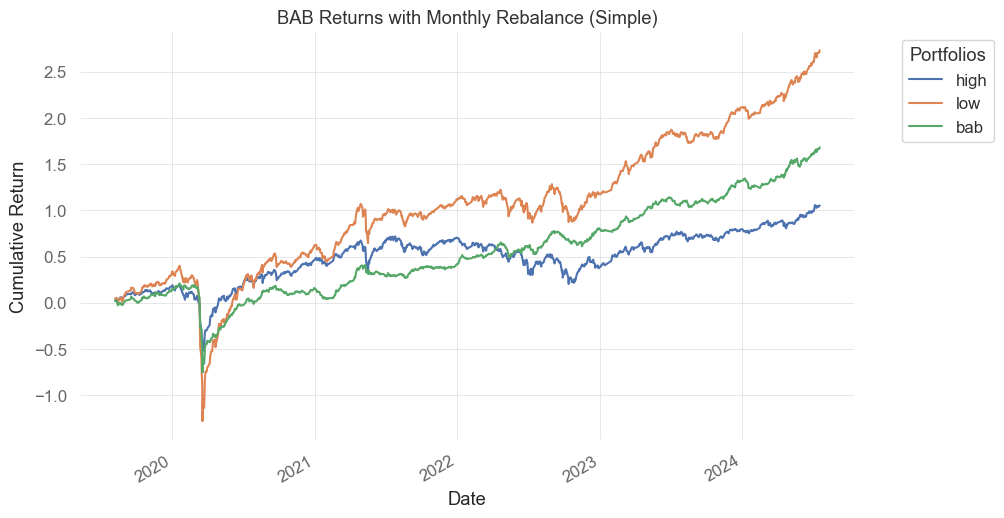

In [103]:
bab_return = pd.DataFrame()
bab_return['high'] = stocks.groupby('Date')['ret_h_m'].sum() / stocks.groupby('Date')['beta_h_m'].sum()
bab_return['low'] = stocks.groupby('Date')['ret_l_m'].sum() / stocks.groupby('Date')['beta_l_m'].sum()
bab_return['bab'] = bab_return['low'] - bab_return['high']

bab_return.cumsum().plot()

plt.title('BAB Returns with Monthly Rebalance (Simple)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(title='Portfolios', bbox_to_anchor=(1.05, 1), loc='upper left')

qs.reports.metrics(bab_return)

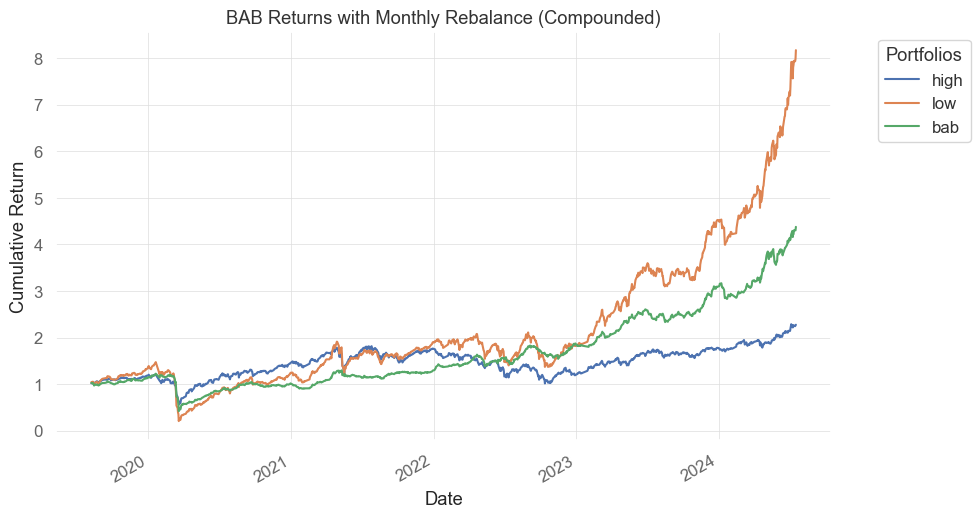

In [101]:
(bab_return + 1).cumprod().plot()

plt.title('BAB Returns with Monthly Rebalance (Compounded)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(title='Portfolios', bbox_to_anchor=(1.05, 1), loc='upper left')